# Conditional sampling evaluation

In [1]:
# Imports

import os
import torch

from jointformer.configs.dataset import DatasetConfig
from jointformer.utils.datasets.auto import AutoDataset

from jointformer.utils.runtime import set_seed

import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
os.chdir("/home/aih/adam.izdebski/project/jointformer-interface/jointformer")

## Fine-tune

In [3]:
# Set logging

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# set seed
SEED = 1337

set_seed(SEED)

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# Configs

TARGET_NAME = 'sa'
TARGET_VALUE = 0.7

DATA_DIR = '/lustre/groups/aih/jointformer/icml25/data'
PATH_TO_DATASET_CONFIG   = f'configs/datasets/guacamol_{TARGET_NAME}/config.json'

PATH_TO_GENERATED_SAMPLES = f'/lustre/groups/aih/jointformer/results_icml25_rebuttal/conditional_sampling_corrected/{TARGET_NAME}/llama_backbone/max_epochs_10/decay_lr_true/batch_size_256/learning_rate_5e-4/weight_decay_1e-1/pooler_dropout_0.0/seed_0/temperature_0.9_top_k_10/generated_samples_{TARGET_NAME}.csv'
# PATH_TO_GENERATED_SAMPLES = f'/lustre/groups/aih/jointformer/results_icml25_rebuttal/conditional_sampling_corrected_no_joint/{TARGET_NAME}/llama_backbone/max_epochs_10/decay_lr_true/batch_size_256/learning_rate_5e-4/weight_decay_1e-1/pooler_dropout_0.0/seed_0/temperature_0.9_top_k_10/generated_samples_{TARGET_NAME}.csv'

# check if paths exist
assert os.path.exists(PATH_TO_GENERATED_SAMPLES), f'Path to model checkpoint does not exist: {PATH_TO_GENERATED_SAMPLES}'


In [5]:
# Load dataset

dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)
train_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='train')


Converting target to float32.


In [7]:
min(train_dataset.target)

array([0.17], dtype=float32)

In [8]:
max(train_dataset.target)

array([1.], dtype=float32)

In [569]:
# Load samples

_df = pd.read_csv(PATH_TO_GENERATED_SAMPLES)

# Subsample

_df = _df[:100000]

In [570]:
_df

,idx,smiles,properties,oracle_values,is_valid_smiles
0,0,CCCCC(=O)N1CCC(c2cc(C)c3nc(-c4cnn(C)c4)ccc3c2)...,0.761403,4.3016,True
1,0,CN(Cc1ccccc1)CC1OCC2CCN(Cc3cccnc3)CC21,-0.077188,2.8320,True
2,0,NC(=O)c1cc(Br)c2ccccc2c1O,-0.576552,1.9988,True
3,0,O=c1c2c(O)cc(O)cc2nc2cccc([N+](=O)[O-])c12,-0.843218,NaN,False
4,0,CC(=Cc1ccccc1)CN(C)C,-0.298256,2.5467,True
...,...,...,...,...,...
99995,48,CCCCCCCCC(=O)C(F)(F)F,0.484833,3.8684,True
99996,48,COc1ccc(C(=O)C=Cc2ccc3occc(=O)c3c2)cc1,0.012981,3.0015,True
99997,48,O=C(O)c1ccccc1SSc1ccc(Br)cc1,0.974081,4.5650,True
99998,48,COc1ccc2c(c1)C1(C)CCN(C)C(C2)C1,-0.096980,2.8873,True


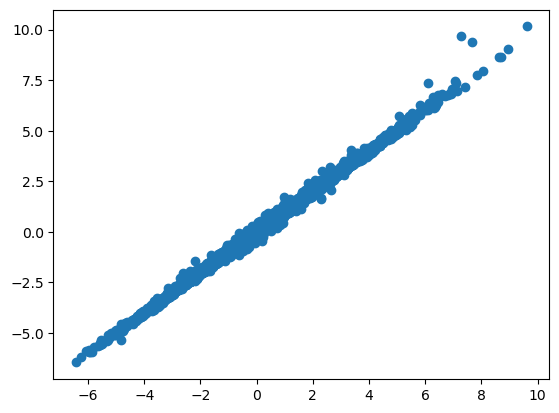

In [571]:
# scatterplot

import matplotlib.pyplot as plt

plt.scatter(_df['properties'], train_dataset.target_transform(_df['oracle_values']))

In [572]:
### best-of-K sampling (if you best of K is simply choosing _epsilon such that at least one sample is selected at every iteration)

samples = []
oracle_values = []
is_valid_sample = []

for idx in _df['idx'].unique():
    # get samples
    _samples = _df[_df['idx'] == idx]['smiles'].tolist()
    # get scores
    _oracle_values = _df[_df['idx'] == idx]['oracle_values'].tolist()
    # get idx
    _properties = _df[_df['idx'] == idx]['properties'].tolist() 
    # get is_valid_sample
    _is_valid_sample = _df[_df['idx'] == idx]['is_valid_smiles'].tolist()

    # get scores
    _scores = np.abs(np.array(_properties) - train_dataset.target_transform(TARGET_VALUE))
    _best_idx = np.argmin(_scores)

    samples.append(_samples[_best_idx])
    oracle_values.append(_oracle_values[_best_idx])
    is_valid_sample.append(_is_valid_sample[_best_idx])

oracle_values = np.array(oracle_values)


In [573]:
# Filter out NaNs
oracle_values = oracle_values[~np.isnan(oracle_values)]

# Sampled
print(f'Sampled {len(samples)} samples')

# Calculate metrics
print('---*---')
mad = np.mean(np.abs(oracle_values - TARGET_VALUE))
print(f'MAD (oracle space): {mad:.3f}')
std = np.std(oracle_values)
print(f'STD (oracle space): {std:.3f}')
# print('---*---')
# mad = np.mean(np.abs(train_dataset.target_transform(oracle_values) - train_dataset.target_transform(TARGET_VALUE)))
# print(f'MAD (normalized space): {mad:.3f}')
# std = np.std(train_dataset.target_transform(oracle_values))
# print(f'STD (normalized space): {std:.3f}')
# print('---*---')
validity = len(is_valid_sample) / len(samples)
print(f'Validity: {validity:.3f}')


Sampled 49 samples
---*---
MAD (oracle space): 0.047
STD (oracle space): 0.063
Validity: 1.000


In [574]:
### Joint sampling 

_epsilon = 0.001

_scores = np.abs(np.array(_df['properties']) - train_dataset.target_transform(TARGET_VALUE))
samples = _df.loc[_scores < _epsilon, 'smiles'].tolist()
oracle_values = _df.loc[_scores < _epsilon, 'oracle_values']
is_valid_sample = _df.loc[_scores < _epsilon, 'is_valid_smiles']

In [575]:
# Filter out NaNs
oracle_values = oracle_values[~oracle_values.isna()]

# Sampled
print(f'Sampled {len(samples)} samples')

# Calculate metrics
print('---*---')
mad = np.mean(np.abs(oracle_values - TARGET_VALUE))
print(f'MAD (oracle space): {mad:.3f}')
std = np.std(oracle_values)
print(f'STD (oracle space): {std:.3f}')
# print('---*---')
# mad = np.mean(np.abs(train_dataset.target_transform(oracle_values) - train_dataset.target_transform(TARGET_VALUE)))
# print(f'MAD (normalized space): {mad:.3f}')
# std = np.std(train_dataset.target_transform(oracle_values))
# print(f'STD (normalized space): {std:.3f}')
# print('---*---')
validity = sum(is_valid_sample) / len(is_valid_sample)
print(f'Validity: {validity:.3f}')


Sampled 67 samples
---*---
MAD (oracle space): 0.047
STD (oracle space): 0.058
Validity: 0.985


In [576]:
samples

['COc1ccc(C(=O)c2c(NC(=O)c3ccccn3)sc3c2CCCC3)cc1',
 'CCC1CC(=O)CCC1(O)CCC=C1CCCC2CC21',
 'CCCCCCCCCCCN1c2nccc[n+]2CC1(O)c1ccco1',
 'CC(=O)Oc1cccc2c1C13CCN(C)C(C2)C1C=C(OCc1ccccc1)C(=O)C3',
 'Cc1cc(N)nc(CC2CNCC23c2ccccc2CCc2ccccc23)n1',
 'CC(C)C1=C(C(=O)NC(C)(C)C)C(c2ccc(O)c(Br)c2)OC1',
 'N=C1NC(c2cc(NC(=O)c3ccc(C#CC4CC4)cn3)ccc2F)(C(F)F)CC(C(F)(F)F)O1',
 'CCCCC12c3ccccc3C(=NO)CC1(O)CCCC2',
 'O=S(=O)(c1ccc(-c2ccc3cnn(O)c3c2)cc1)N1CCCC(c2ccccc2)C1',
 'O=C(O)CCCCCCCCCCCC(=O)Nc1ccc(N2C(=O)CCC2=O)cc1',
 'CCOCC1CCN(C(=O)c2ccc3cc(Oc4ccc(C(F)(F)F)cn4)ccc3n2)C1',
 'COc1cc(F)c(CON=C2c3ccccc3C(=O)c3c([N+](=O)[O-])cccc32)c(F)c1',
 'O=S(=O)(c1ccccc1)c1nnn2c1nc(Nc1ccccc1F)c1sccc12',
 'Cc1ccsc1C=CC(=O)c1ccccc1F',
 'O=C(c1ccc2c(c1)CCCN2C(=O)c1ccccc1)c1ccccc1',
 'Cc1ccc(S(=O)(=O)Nc2cccc(Cl)c2C)cc1N(C)S(=O)(=O)c1cccs1',
 'CC(C)=CC(=O)NC1=CC(=O)C2=C(C1=O)C1(C)CCCC(C)(C)C1CC2',
 'CCC(C=CC(=O)NC(Cc1ccc(OC)cc1)C(=O)C(F)(F)C(=O)OC)NC(=O)C(CC(C)C)NC(=O)OCc1ccccc1',
 'COc1c(C)c(OC)c(Br)c2c1C(=O)c1c(cc(C)c(Br)c

In [577]:
list_valid_sample = is_valid_sample.tolist()
valid_samples = [samples[i] for i in range(len(samples)) if list_valid_sample[i]][:3]

In [578]:
# all_samples = []
all_samples.extend(valid_samples)

In [579]:
len(all_samples)

27

In [580]:
all_samples

['Cc1cc(N2CCCCC2)n2nc(C)[n+](CC(=O)c3ccc(Cl)cc3)c2n1',
 'CCN(CC(=O)Nc1ccccc1OC)C(=O)c1ccc(S(=O)(=O)N(C)c2ccccc2)cc1',
 'COc1cc2ccnc(Cc3ccc4cccc(OCC(C)N)c4n3)c2cc1OC',
 'COc1ccc(C(=O)OCC(=O)NC2CC2)cc1S(=O)(=O)N1CCCCC1',
 'O=C1NCCc2c1[nH]c1ccc(Cl)cc21',
 'CC(=O)NC(C)Cc1ccc(C#Cc2cnc(Oc3ccccc3)nc2)cc1',
 'CC(NC(=O)c1ccccc1)C(=O)N1CCCCC1',
 'Cc1ccccc1NC(=O)c1ccc2c(c1)OCO2',
 'O=C(Nc1ccc2c(c1)OCCO2)C(c1ccccc1F)N1CCCCC1',
 'OC1=C2c3ccccc3-c3ccccc3C23CCN(CCc2cccnc2)CC31',
 'Cc1ccc(S(=O)(=O)C2(c3ccc(NC(=O)N(C)OC)cc3)CCN(C(=O)C3(C)CCC(C(=O)O)CC3)C2)cc1F',
 'Cc1cc(C(=O)NC(CC(C)C)C(=O)NC(C=O)CCCNC(=N)N)ccc1NC(=O)C1Cc2c(Cl)cccc2C1',
 'CC(C)(C)c1cc(NC(=O)CN2CCCN(Cc3ccc(Cl)cc3)S2(=O)=O)no1',
 'CCC(=O)c1c(O)cccc1OCC(O)CN(C(C)(C)C)Cc1ccccc1',
 'N=C(O)N1CCCc2cc(-c3cncc(Cl)c3)cnc21',
 'COc1ccccc1NC(=O)c1csc(-c2cccc3ccccc23)n1',
 'Cc1ccc(S(=O)(=O)CC=Cc2ccccc2)cc1',
 'CC(=O)Nc1ccc(S(=O)(=O)N2CCN(C(=O)C3CC3)CC2)cc1',
 'Cc1cc([N+](=O)[O-])cc(NC(=O)CN2CCNC(=O)C2)c1C',
 'CCC(C)NC(=O)c1cn(C)nc1OS(C)(=O)=O',
 'C

In [583]:
{"qed=0.5": all_samples[0:3],
 "qed=0.7": all_samples[3:6],
 "qed=0.9": all_samples[6:9],
 "sa=0.7": all_samples[9:12],
 "sa=0.8": all_samples[12:15],
 "sa=0.9": all_samples[15:18],
 "logp=0.0": all_samples[18:21],
 "logp=2.0": all_samples[21:24],
 "logp=4.0": all_samples[24:27]}

{'qed=0.5': ['Cc1cc(N2CCCCC2)n2nc(C)[n+](CC(=O)c3ccc(Cl)cc3)c2n1',
  'CCN(CC(=O)Nc1ccccc1OC)C(=O)c1ccc(S(=O)(=O)N(C)c2ccccc2)cc1',
  'COc1cc2ccnc(Cc3ccc4cccc(OCC(C)N)c4n3)c2cc1OC'],
 'qed=0.7': ['COc1ccc(C(=O)OCC(=O)NC2CC2)cc1S(=O)(=O)N1CCCCC1',
  'O=C1NCCc2c1[nH]c1ccc(Cl)cc21',
  'CC(=O)NC(C)Cc1ccc(C#Cc2cnc(Oc3ccccc3)nc2)cc1'],
 'qed=0.9': ['CC(NC(=O)c1ccccc1)C(=O)N1CCCCC1',
  'Cc1ccccc1NC(=O)c1ccc2c(c1)OCO2',
  'O=C(Nc1ccc2c(c1)OCCO2)C(c1ccccc1F)N1CCCCC1'],
 'sa=0.7': ['OC1=C2c3ccccc3-c3ccccc3C23CCN(CCc2cccnc2)CC31',
  'Cc1ccc(S(=O)(=O)C2(c3ccc(NC(=O)N(C)OC)cc3)CCN(C(=O)C3(C)CCC(C(=O)O)CC3)C2)cc1F',
  'Cc1cc(C(=O)NC(CC(C)C)C(=O)NC(C=O)CCCNC(=N)N)ccc1NC(=O)C1Cc2c(Cl)cccc2C1'],
 'sa=0.8': ['CC(C)(C)c1cc(NC(=O)CN2CCCN(Cc3ccc(Cl)cc3)S2(=O)=O)no1',
  'CCC(=O)c1c(O)cccc1OCC(O)CN(C(C)(C)C)Cc1ccccc1',
  'N=C(O)N1CCCc2cc(-c3cncc(Cl)c3)cnc21'],
 'sa=0.9': ['COc1ccccc1NC(=O)c1csc(-c2cccc3ccccc23)n1',
  'Cc1ccc(S(=O)(=O)CC=Cc2ccccc2)cc1',
  'CC(=O)Nc1ccc(S(=O)(=O)N2CCN(C(=O)C3CC3)CC2)cc1'],
 'lo

In [581]:
all_samples[3]

'COc1ccc(C(=O)OCC(=O)NC2CC2)cc1S(=O)(=O)N1CCCCC1'